# SMIB with AVR and PSS

In [1]:
import sys
sys.path.append('/home/jmmauricio/Documents/public/workspace/pydss/pydss')
from solvers import nr,ssa

In [2]:
import numpy as np 
import sympy as sym
from sympy.utilities.lambdify import lambdify, implemented_function
import scipy.signal as ctrl
import scipy.optimize as sopt
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 

sin = sym.sin
cos = sym.cos

## PSS Tunning

Before modelling synchronous machine with the PSS this will be tunned.

### Model with AVR and  without PSS 

In [3]:
delta, omega, e1d, e1q = sym.symbols('delta omega e1d e1q')
i_d, i_q, v_d, v_q = sym.symbols('i_d i_q v_d v_q')
v_f, p_m = sym.symbols('v_f p_m')
X_d, X_q, X1d, X1q, X_l, R_a, T1d0, T1q0  = sym.symbols('X_d X_q X1d X1q X_l R_a T1d0 T1q0')
H, D = sym.symbols('H D')
V_t, theta_t, P_t, Q_t, V_inf, theta_inf = sym.symbols('V_t, theta_t, P_t, Q_t, V_inf, theta_inf')
B_t_inf, B_t0, G_t_inf, G_t0 = sym.symbols('B_t_inf, B_t0, G_t_inf, G_t0')
Omega_b, p_e = sym.symbols('Omega_b p_e')
v_c, K_a, T_r,V_ref, v_f_avr = sym.symbols('v_c, K_a, T_r,V_ref, v_f_avr')

In [4]:
N_x = 5
N_y = 10

ddelta = Omega_b * (omega - 1);
domega = 1/(2*H) * ( p_m - p_e - D * ( omega - 1)) ;
de1q   = 1/T1d0 * ( -e1q - (X_d - X1d ) * i_d + v_f);
de1d   = 1/T1q0 * ( -e1d + (X_q - X1q ) * i_q ) 
dv_c   = 1/T_r * ( V_t - v_c )


g1 = v_q + R_a * i_q - e1q + (X1d - X_l)*i_d;
g2 = v_d + R_a * i_d - e1d - (X1q - X_l)*i_q;
g3 = p_e - (v_q + R_a*i_q)*i_q - (v_d + R_a*i_d)*i_d ;
g4 = v_d - V_t * sin(delta - theta_t);
g5 = v_q - V_t * cos(delta - theta_t);
g6 = v_d * i_d + v_q * i_q - P_t; 
g7 = v_q * i_d - v_d * i_q - Q_t;
g8 =  V_t**2*(G_t_inf+G_t0) - V_t*V_inf*(G_t_inf * cos(theta_t - theta_inf) + B_t_inf * sin(theta_t - theta_inf)) - P_t  
g9 = -V_t**2*(B_t_inf+B_t0) - V_t*V_inf*(G_t_inf * sin(theta_t - theta_inf) - B_t_inf * cos(theta_t - theta_inf)) - Q_t
g10 = K_a*(V_ref - v_c) - v_f


In [5]:
x = sym.Matrix([delta,omega,e1q,e1d,v_c])
f = sym.Matrix([ddelta, domega, de1q, de1d, dv_c])

y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,p_m,V_ref,theta_t,Q_t, v_f])
g = sym.Matrix([ g1, g2, g3, g4, g5, g6,   g7,     g8, g9, g10])

In [6]:
F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [7]:
X_d = 1.81
X1d  = 0.3
T1d0  = 8.0
X_q  = 1.76
X1q  = 0.65
T1q0  = 1.0 
R_a  =  0.003 
X_l  = 0.15  
H  = 3.5   
Omega_b = 2*np.pi*60
Z_t_inf = 0.15+1.0/(1.0/0.5+1.0/0.93)

params_ini = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'D' : 0.1,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.0, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
'K_a':10.0,   
'T_r':0.05,  
}


### Initialization problem (backward)

In [8]:
u = sym.Matrix([P_t,V_t])

f_eval = lambdify((x,y,u), f.subs(params_ini), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_ini), "numpy")
F_x_eval = lambdify((x,y,u), F_x.subs(params_ini), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_ini), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_ini), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_ini), "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)


lam = lambdify((xi_sym,u), lam_sym.subs(params_ini), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_ini), "numpy")

In [9]:
xi_0 = np.ones((N_x+N_y,1))
u_0 = np.array([0.9,1.0])
xi_ini = nr(xi_0,u_0,lam,Lam)

### Simulation problem (forward)

In [10]:
N_x = 5
N_y = 10

x = sym.Matrix([delta,omega,e1q,e1d,v_c])
y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,P_t,Q_t,theta_t,V_t,v_f])
u = sym.Matrix([p_m,V_ref,D,K_a])

f = sym.Matrix([ddelta, domega, de1q, de1d, dv_c])
g = sym.Matrix([g1, g2, g3, g4, g5,g6, g7, g8,g9,g10])
h = sym.Matrix([P_t,Q_t,V_t])

F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)
F_u = f.jacobian(u)
G_u = g.jacobian(u)
H_x = f.jacobian(x)
H_u = g.jacobian(u)

In [11]:
params_run = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.01, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
'T_r':0.05,  
}

f_eval = lambdify((x,y,u), f.subs(params_run), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_run), "numpy")

F_x_eval = lambdify((x,y,u), F_x.subs(params_run), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_run), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_run), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_run), "numpy")

F_u_eval = lambdify((x,y,u), F_u.subs(params_run), "numpy")
G_u_eval = lambdify((x,y,u), G_u.subs(params_run), "numpy")
H_x_eval = lambdify((x,y,u), H_x.subs(params_run), "numpy")
H_u_eval = lambdify((x,y,u), H_u.subs(params_run), "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)
 

lam = lambdify((xi_sym,u), lam_sym.subs(params_run), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_run), "numpy")
h_eval = lambdify((xi_sym,u), h.subs(params_run), "numpy")

In [12]:
# u = sym.Matrix([p_m,V_ref,D,K_a])
u_0 = np.array((xi_ini[10,0],xi_ini[11,0],params_ini['D'],params_ini['K_a']))
xi_0 = np.ones((N_x+N_y,1))
xi_ini = nr(xi_0,u_0,lam,Lam)

In [13]:
lam(xi_0,u_0)

array([[ 0.        ],
       [-0.0138571 ],
       [-0.18875   ],
       [ 0.11      ],
       [ 0.        ],
       [ 0.153     ],
       [-0.497     ],
       [-1.006     ],
       [ 1.        ],
       [ 0.        ],
       [ 1.        ],
       [-1.        ],
       [ 0.59521388],
       [ 0.07021354],
       [ 1.28219166]])

<IPython.core.display.Javascript object>


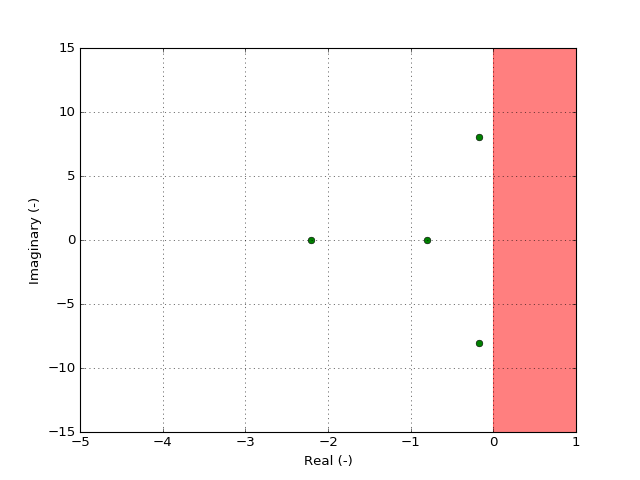

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_animated(True)
plt.xlim(-5, 1)
plt.ylim(-15, 15)
plt.grid(True)
ax.set_ylabel('Imaginary (-)')
ax.set_xlabel('Real (-)')
poles = ax.plot([], 'o', ms=8) 
plt.grid(True)

poles = ax.plot([], 'o') 
#display(fig)

r1 = patches.Rectangle((0,-100), 500, 200, color="red", alpha=0.5)
ax.add_patch(r1)

lam_avr = lam
Lam_avr = Lam
h_eval_avr = h_eval
N_x_avr = N_x
u_0_avr = np.copy(u_0)
xi_0_avr = np.copy(xi_0)
def update_avr(p_m,v_ref,D,K_a):
    
    u_0 = np.array([p_m,v_ref,D,K_a])
    lambdas, z,freqs,zetas = ssa(xi_0_avr,u_0_avr,lam_avr,Lam_avr,h_eval_avr,N_x_avr)
    poles[0].set_xdata(lambdas.real)
    poles[0].set_ydata(lambdas.imag)
    
    print('P   = {:2.2f}'.format(z[0,0]))
    print('Q   = {:2.2f}'.format(z[1,0]))
    print('V_t = {:2.2f}'.format(z[2,0]))



sld_p_m = widgets.FloatSlider(min=0,max=1.2,step=0.01,value=u_0[0])
sld_v_ref = widgets.FloatSlider(min=u_0[1]-0.5,max=u_0[1]+0.5,step=0.01,value=u_0[1])
sld_D = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=u_0[2])
sld_Ka = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=u_0[3])
interaction_avr = interactive(update_avr,
                          p_m=sld_p_m,
                          v_ref=sld_v_ref,
                          D=sld_D,
                          K_a=sld_Ka,
                          continuous_update=False)    

In [15]:
display(interaction_avr)

P   = 0.90
Q   = 0.43
V_t = 1.00


In [16]:
fig.savefig('poles_avr.svg',bbox_inches='tight')

## Trapezoidal

In [17]:
N_steps = 1000
max_iter = 1
t = 0.0;

u_0 = np.array([0.5,1.0,0.1,20])
u_i = u_0

xi_0 = nr(xi_0,u_0,lam,Lam)
x_0 = xi_0[0:N_x]
y_0 = xi_0[N_x:(N_x+N_y)]
lambdas, z,freqs,zetas = ssa(xi_0,u_0,lam,Lam,h_eval,N_x)

sigmas = lambdas.real
omegas = lambdas.imag

freqs = omegas/(2*np.pi);
zetas = sigmas/np.sqrt(sigmas**2+omegas**2)


N_x = x_0.shape[0]
N_y = y_0.shape[0]
X = np.zeros((N_steps,N_x));
Y = np.zeros((N_steps,N_y));
T = np.zeros((N_steps,1));
Dt = 10.0e-3


    
for it in range(N_steps):
    x_i = np.copy(x_0)
    y_i = np.copy(y_0)
   
    if t>0.0:
        u_i[1] = 1.1
    for iter in range(max_iter): 
        
        A_c_i = np.vstack([np.hstack([np.eye(N_x) - 0.5*Dt*F_x_eval(x_i,y_i,u_i), -0.5*Dt*F_y_eval(x_i,y_i,u_i)]),
                           np.hstack([                     G_x_eval(x_i,y_i,u_i),         G_y_eval(x_i,y_i,u_i)])])
             
        f_n_i = x_i - x_0 - 0.5*Dt*(f_eval(x_i,y_i,u_i)+f_eval(x_0,y_0,u_i))
        
        Dxy_i = -np.linalg.solve(A_c_i, np.vstack((f_n_i,g_eval(x_i,y_i,u_i))))
        
        x_i = x_i + Dxy_i[0:N_x]
        y_i = y_i + Dxy_i[N_x:(N_x+N_y)]
        
        if np.linalg.norm(Dxy_i,np.inf)<1.0e-8:
            break

    x_0 = x_i
    y_0 = y_i
   
    T[it,:] = t;
    X[it,:] = x_i[:,0];
    Y[it,:] = y_i[:,0];    
    t = it*Dt;

<IPython.core.display.Javascript object>


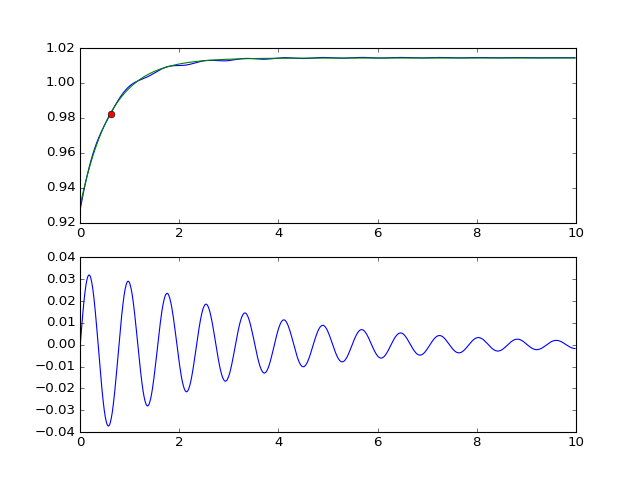

[-0.38]
Tau: 0.623


In [18]:
V_t = Y[:,-2]
V_t_ini =  V_t[0]
V_t_end =  V_t[-1]
V_t_063 = 0.63*(V_t_end - V_t_ini)+V_t_ini

def func(x, a, b, c, d):
    
    return a*(1-np.exp(-c*(x-b)))+d

popt, pcov = curve_fit(func, T[:,0], V_t, [0.1,1.0,10,V_t_ini])
a, b, c, d = popt
V_t_fit = func(T, a, b, c, d )

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(T,(Y[:,-2]))
ax1.plot(T,V_t_fit)
ax1.plot(T[V_t>V_t_063][0],V_t_063,'o')
ax2.plot(T,Y[:,2]-0.5) 
#display(fig)

print(T[V_t>V_t_063][0]-1.0)
print('Tau: {:2.3f}'.format(1/popt[2]))

fig.savefig('fit_pss_omega.svg',bbox_inches='tight')



## PSS parameters

### Open loop

In [19]:
G_syn = ctrl.lti([1],[1/popt[2], 1])

<IPython.core.display.Javascript object>


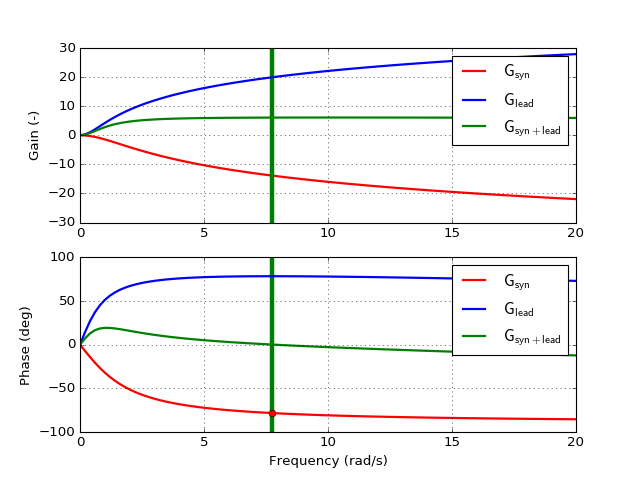

In [20]:
w = np.linspace(0.0,20,100)
w, mag, phase = ctrl.bode(G_syn,w)
omega_osc = omegas[1]
ph = phase[w>omega_osc][0]

fig_bode = plt.figure()
ax1 = fig_bode.add_subplot(211)
ax2 = fig_bode.add_subplot(212)
ax1.plot(w,mag, 'r', lw=2, label='$\sf G_{syn}$')
ax2.plot(w,phase, 'r', lw=2, label='$\sf G_{syn}$')

ax1.plot([omega_osc,omega_osc],[-30,30], 'g', lw=4)
ax2.plot([omega_osc,omega_osc],[-100,100],'g', lw=4)
ax2.plot([omega_osc],ph, 'o', lw=4, color = 'r')
ax1.grid(True)
ax2.grid(True)

#ax1.set_xlabel('Frequency (rad/s)')
ax2.set_xlabel('Frequency (rad/s)')
ax1.set_ylabel('Gain (-)')
ax2.set_ylabel('Phase (deg)')



### Lead compensator

In [21]:
def lead_solver(x):
    a = x[0]
    T = x[1]
    
    phi = -ph/180*np.pi
    w = omega_osc
    
    if a<0.001: a= 0.001
    if T<0.001: T= 0.001
    eq1 = w - 1.0/(T*np.sqrt(a))
    eq2 = np.sin(phi) - (a-1)/(a+1)
    
    return [eq1,eq2]

x_lead = [1,1]
sol_lead = sopt.fsolve(lead_solver,x_lead)

In [22]:
a_lead,T_lead = sol_lead
T_pss_1_val = a_lead*T_lead
T_pss_2_val = T_lead

G_lead = ctrl.lti([a_lead*T_lead, 1],[T_lead, 1])
w_lead, mag_lead, phase_lead = ctrl.bode(G_lead, w)
ax1.plot(w_lead,mag_lead, 'b', lw=2, label='$\sf G_{lead}$')
ax2.plot(w_lead,phase_lead, 'b', lw=2, label='$\sf G_{lead}$') 

### Compensated system

In [23]:
den = np.convolve([1/popt[2], 1],[T_lead, 1])

In [24]:
G_comp = ctrl.lti([a_lead*T_lead, 1],den)

In [25]:
w_comp, mag_comp, phase_comp = ctrl.bode(G_comp, w)
ax1.plot(w_comp,mag_comp, 'g', lw=2.0, label='$\sf G_{syn+lead}$')
ax2.plot(w_comp,phase_comp, 'g', lw=2.0, label='$\sf G_{syn+lead}$') 

ax1.legend()
ax2.legend()


In [26]:
fig_bode.savefig('bodes.svg')

## System with PSS

In [27]:
delta, omega, e1d, e1q = sym.symbols('delta omega e1d e1q')
i_d, i_q, v_d, v_q = sym.symbols('i_d i_q v_d v_q')
v_f, p_m = sym.symbols('v_f p_m')
X_d, X_q, X1d, X1q, X_l, R_a, T1d0, T1q0  = sym.symbols('X_d X_q X1d X1q X_l R_a T1d0 T1q0')
H, D = sym.symbols('H D')
V_t, theta_t, P_t, Q_t, V_inf, theta_inf = sym.symbols('V_t, theta_t, P_t, Q_t, V_inf, theta_inf')
B_t_inf, B_t0, G_t_inf, G_t0 = sym.symbols('B_t_inf, B_t0, G_t_inf, G_t0')
Omega_b, p_e = sym.symbols('Omega_b p_e')
v_c, K_a, T_r,V_ref, v_f_avr = sym.symbols('v_c, K_a, T_r,V_ref, v_f_avr')
x_pss, v_pss, T_pss_1, T_pss_2,K_stab = sym.symbols('x_pss, v_pss, T_pss_1, T_pss_2,K_stab ')
x_w, omega_w, T_w = sym.symbols('x_w, omega_w, T_w ')

In [28]:
N_x = 7
N_y = 12

ddelta = Omega_b * (omega - 1);
domega = 1/(2*H) * ( p_m - p_e - D * ( omega - 1)) ;
de1q   = 1/T1d0 * ( -e1q - (X_d - X1d ) * i_d + v_f);
de1d   = 1/T1q0 * ( -e1d + (X_q - X1q ) * i_q ) 
dv_c   = 1/T_r * ( V_t - v_c )
dx_pss = 1.0/T_pss_2*(omega_w - x_pss)
dx_w = 1.0/T_w*(omega - x_w)

g1 = v_q + R_a * i_q - e1q + (X1d - X_l)*i_d;
g2 = v_d + R_a * i_d - e1d - (X1q - X_l)*i_q;
g3 = p_e - (v_q + R_a*i_q)*i_q - (v_d + R_a*i_d)*i_d ;
g4 = v_d - V_t * sin(delta - theta_t);
g5 = v_q - V_t * cos(delta - theta_t);
g6 = v_d * i_d + v_q * i_q - P_t; 
g7 = v_q * i_d - v_d * i_q - Q_t;
g8 =  V_t**2*(G_t_inf+G_t0) - V_t*V_inf*(G_t_inf * cos(theta_t - theta_inf) + B_t_inf * sin(theta_t - theta_inf)) - P_t  
g9 = -V_t**2*(B_t_inf+B_t0) - V_t*V_inf*(G_t_inf * sin(theta_t - theta_inf) - B_t_inf * cos(theta_t - theta_inf)) - Q_t
g10 = K_a*(V_ref + v_pss - v_c) - v_f
g11 = v_pss - K_stab*(T_pss_1/T_pss_2*omega_w + (1.0-1.0/T_pss_2)*x_pss)
g12 = omega_w - (omega - x_w)

In [29]:
x = sym.Matrix([delta,omega,e1q,e1d,v_c,x_pss,x_w])
y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,P_t,Q_t,theta_t,V_t,v_f,v_pss,omega_w])
u = sym.Matrix([p_m,V_ref,D,K_a,K_stab])

f = sym.Matrix([ddelta, domega, de1q, de1d, dv_c,dx_pss,dx_w])
g = sym.Matrix([g1, g2, g3, g4, g5,g6, g7, g8,g9,g10,g11,g12])
h = sym.Matrix([P_t,Q_t,V_t])

F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)
F_u = f.jacobian(u)
G_u = g.jacobian(u)
H_x = f.jacobian(x)
H_u = g.jacobian(u)

In [30]:
X_d = 1.81
X1d  = 0.3
T1d0  = 8.0
X_q  = 1.76
X1q  = 0.65
T1q0  = 1.0 
R_a  =  0.003 
X_l  = 0.15  
H  = 3.5   
Omega_b = 2*np.pi*60
Z_t_inf = 0.15+1.0/(1.0/0.5+1.0/0.93)

params_run = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.01, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
'T_r':0.05,  
'theta_inf':0.0,   
'T_r':0.05,  
'T_pss_1':T_pss_1_val,
'T_pss_2':T_pss_2_val,
'T_w':5.0
}

f_eval = lambdify((x,y,u), f.subs(params_run), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_run), "numpy")

F_x_eval = lambdify((x,y,u), F_x.subs(params_run), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_run), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_run), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_run), "numpy")

F_u_eval = lambdify((x,y,u), F_u.subs(params_run), "numpy")
G_u_eval = lambdify((x,y,u), G_u.subs(params_run), "numpy")
H_x_eval = lambdify((x,y,u), H_x.subs(params_run), "numpy")
H_u_eval = lambdify((x,y,u), H_u.subs(params_run), "numpy")

sys = [f_eval,g_eval,F_x_eval,F_y_eval,G_x_eval,G_y_eval,F_u_eval,G_u_eval,H_x_eval,H_u_eval]
lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)
 

lam = lambdify((xi_sym,u), lam_sym.subs(params_run), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_run), "numpy")
h_eval = lambdify((xi_sym,u), h.subs(params_run), "numpy")

In [31]:
xi_0 = np.ones((19,1))
#xi_0[-6] = 0.9
#xi_0[-1] = 0.0
p_m = 0.1
V_ref = 1.0
D= 0.0
K_a = 30.0
K_stab = 5.0
u_val = np.array([p_m,V_ref,D,K_a,K_stab])
xi_0 = nr(xi_0,u_val,lam,Lam)


In [32]:
N_steps = 1000
max_iter = 1
t = 0.0;

u_val[0] = 0.2
u_0 = u_val
u_i = u_0

xi_0 = nr(xi_0,u_0,lam,Lam)
x_0 = xi_0[0:N_x]
y_0 = xi_0[N_x:(N_x+N_y)]
lamb,z,omegas,zetas = ssa(xi_0,u_val, lam, Lam, h_eval, N_x)

sigmas = lamb.real
omegas = lamb.imag

freqs = omegas/(2*np.pi);
zetas = sigmas/np.sqrt(sigmas**2+omegas**2)


N_x = x_0.shape[0]
N_y = y_0.shape[0]
X = np.zeros((N_steps,N_x));
Y = np.zeros((N_steps,N_y));
T = np.zeros((N_steps,1));
Dt = 10.0e-3


    
for it in range(N_steps):
    x_i = np.copy(x_0)
    y_i = np.copy(y_0)
   
    if t>1.0:
        u_i[0] = 1.0
    for iter in range(max_iter): 
        
        A_c_i = np.vstack([np.hstack([np.eye(N_x) - 0.5*Dt*F_x_eval(x_i,y_i,u_i), -0.5*Dt*F_y_eval(x_i,y_i,u_i)]),
                           np.hstack([                     G_x_eval(x_i,y_i,u_i),         G_y_eval(x_i,y_i,u_i)])])
             
        f_n_i = x_i - x_0 - 0.5*Dt*(f_eval(x_i,y_i,u_i)+f_eval(x_0,y_0,u_i))
        
        Dxy_i = -np.linalg.solve(A_c_i, np.vstack((f_n_i,g_eval(x_i,y_i,u_i))))
        
        x_i = x_i + Dxy_i[0:N_x]
        y_i = y_i + Dxy_i[N_x:(N_x+N_y)]
        
        if np.linalg.norm(Dxy_i,np.inf)<1.0e-8:
            break

    x_0 = x_i
    y_0 = y_i
   
    T[it,:] = t;
    X[it,:] = x_i[:,0];
    Y[it,:] = y_i[:,0];    
    t = it*Dt;

<IPython.core.display.Javascript object>


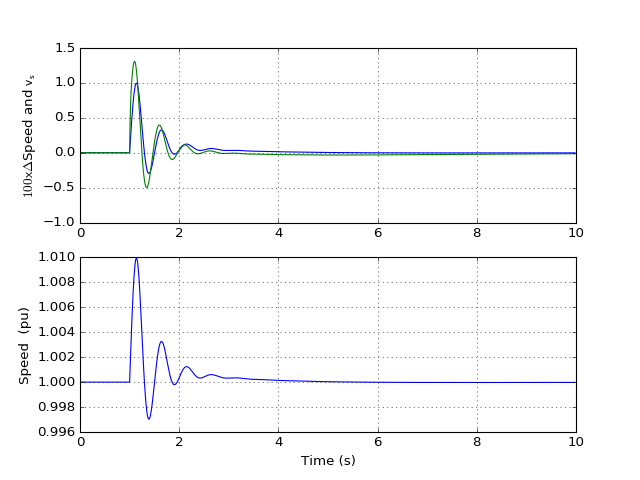

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(T,((X[:,1])-1)*100)
ax1.plot(T,(Y[:,-2]))
ax2.plot(T,X[:,1]) 

ax1.set_ylabel('$\sf 100 x \Delta$Speed and $\sf v_s$')
ax2.set_ylabel('Speed  (pu)')
ax2.set_xlabel('Time (s)')

ax1.grid(True)
ax2.grid(True)
fig.savefig('vs_speeds_pss.svg',bbox_inches='tight')

<IPython.core.display.Javascript object>


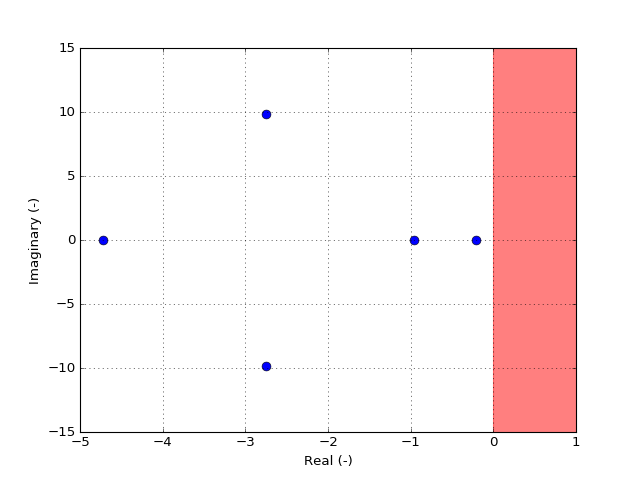

In [34]:
fig = plt.figure()
%config InlineBackend.figure_format = 'svg'
ax = fig.add_subplot(111)
fig.set_animated(True)
plt.xlim(-5, 1)
plt.ylim(-15, 15)
plt.grid(True)
ax.set_ylabel('Imaginary (-)')
ax.set_xlabel('Real (-)')
poles = ax.plot([], 'o', ms=8) 
#display(fig)

r1 = patches.Rectangle((0,-100), 500, 200, color="red", alpha=0.5)
ax.add_patch(r1)

def update(p_m,v_ref,D,K_a,K_stab):
    
    u_0 = np.array([p_m,v_ref,D,K_a,K_stab])
    lambdas, z,freqs,zetas = ssa(xi_0,u_0,lam,Lam,h_eval,N_x)
    poles[0].set_xdata(lambdas.real)
    poles[0].set_ydata(lambdas.imag)
    
    print('P   = {:2.2f}'.format(z[0,0]))
    print('Q   = {:2.2f}'.format(z[1,0]))
    print('V_t = {:2.2f}'.format(z[2,0]))



sld_p_m = widgets.FloatSlider(min=0,max=1.2,step=0.01,value=u_0[0])
sld_v_ref = widgets.FloatSlider(min=u_0[1]-0.5,max=u_0[1]+0.5,step=0.01,value=u_0[1])
sld_D = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=u_0[2])
sld_Ka = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=u_0[3])
sld_Kstab = widgets.FloatSlider(min=0.0,max=100.0,step=0.01,value=u_0[4])
interaction = interactive(update,
                          p_m=sld_p_m,
                          v_ref=sld_v_ref,
                          D=sld_D,
                          K_a=sld_Ka,
                          K_stab=sld_Kstab,
                          continuous_update=False)    

In [35]:
display(interaction)

P   = 0.20
Q   = 0.15
V_t = 0.97


In [36]:
fig.savefig('poles_avr_pss.svg',bbox_inches='tight')

In [39]:
str(f)

'Matrix([[Omega_b*(omega - 1)], [(-D*(omega - 1) - p_e + p_m)/(2*H)], [(-e1q - i_d*(-X1d + X_d) + v_f)/T1d0], [(-e1d + i_q*(-X1q + X_q))/T1q0], [(V_t - v_c)/T_r], [1.0*(omega_w - x_pss)/T_pss_2], [1.0*(omega - x_w)/T_w]])'

In [41]:
sym.utilities.codegen.make_routine('hola', f, argument_sequence=None, global_vars=None, language='F95')[source]

AttributeError: module 'sympy.utilities' has no attribute 'codegen'

In [42]:
from sympy.utilities.codegen import codegen

In [55]:
[(c_name, c_code), (h_name, c_header)] = codegen( ("F_x", F_x), "F95", "test", header=False, empty=False)

In [56]:
print(c_code)

subroutine F_x(D, H, Omega_b, T1d0, T1q0, T_pss_2, T_r, T_w, &
      out_2386475379907361102)
implicit none
REAL*8, intent(in) :: D
REAL*8, intent(in) :: H
REAL*8, intent(in) :: Omega_b
REAL*8, intent(in) :: T1d0
REAL*8, intent(in) :: T1q0
REAL*8, intent(in) :: T_pss_2
REAL*8, intent(in) :: T_r
REAL*8, intent(in) :: T_w
REAL*8, intent(out), dimension(1:7, 1:7) :: out_2386475379907361102
out_2386475379907361102(1, 1) = 0
out_2386475379907361102(2, 1) = 0
out_2386475379907361102(3, 1) = 0
out_2386475379907361102(4, 1) = 0
out_2386475379907361102(5, 1) = 0
out_2386475379907361102(6, 1) = 0
out_2386475379907361102(7, 1) = 0
out_2386475379907361102(1, 2) = Omega_b
out_2386475379907361102(2, 2) = -1.0d0/2.0d0*D/H
out_2386475379907361102(3, 2) = 0
out_2386475379907361102(4, 2) = 0
out_2386475379907361102(5, 2) = 0
out_2386475379907361102(6, 2) = 0
out_2386475379907361102(7, 2) = 1.0d0/T_w
out_2386475379907361102(1, 3) = 0
out_2386475379907361102(2, 3) = 0
out_2386475379907361102(3, 3) = -1/T1